# Demo: Fitting a sine curve

In [2]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="multiprocessing.resource_tracker")

import numpy as np
import matplotlib.pyplot as plt

import nbi

In [3]:
print(nbi.__version__)

0.4.1


Let us consider a very simple sine curve model, where $t$ is time, $\omega$ is angular frequency, $A$ is amplitude, and $\phi_0$ is initial phase:<br>
$f(t) = A\cdot\sin(\omega\cdot t+\phi_0$)

Assume parameters from the following uniform distribution:<br>
$\phi_0\in[0,2\pi]$, $A\in[-4,4]$, $\omega\in[2\pi,12\pi]$

Note that the amplitude is allowed to be negative. Thus expect bi-modal posteriors in the amplitude.

Also assume Gaussian measurement noise fixed to be $\sigma_0$:<br>
$x_{\rm obs}\sim N(f(t), \sigma=\sigma_0)$

In [4]:
t = np.linspace(0,1,50)
def sine(param):
    phi0, A, omega = param
    return np.sin(omega * t + phi0) * A

In [5]:
# nbi requires prior to be defined with scipy functions
# alternatively, you may supply pre-generated parameters with numpy arrays

from scipy.stats import uniform, truncnorm
prior = {
    'phi0': uniform(loc=0, scale=np.pi*2),
    'A': uniform(loc=-4, scale=8),
    'omega': uniform(loc=2*np.pi, scale=10*np.pi)
}
labels = list(prior.keys())
priors = [prior[k] for k in labels]

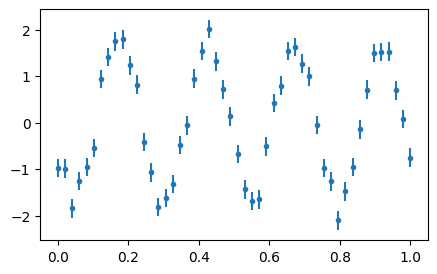

In [20]:
# a randomly drawn sine curve for illustration

plt.figure(figsize=(5,3))
np.random.seed(0)

# draw random parameter from prior
y_true = [var.rvs(1)[0] for var in priors]

# add fixed gaussian noise of 1
x_err = 0.2
x_obs = sine(y_true) + np.random.normal(size=50) * x_err

plt.errorbar(t, x_obs, yerr=x_err, fmt='.')
plt.show()

## Use case 1: Amortized Neural Posterior Estimation
if we want to derive the posterior for a large number of different x_obs, then train nbi for 1 round on a large number of samples generated from the prior.

In [6]:
# the noise function can include any component of the forward model that is cheap
# therefore it takes in both data (x) and parameter (y) as input
# Here let us only consider iid Gaussian noise

def noise(x, y):
    rand = np.random.normal(0, 1, size=x.shape[0])
    
    # let's say x_err is drawn from [0.05, 0.5]
    x_err = np.random.uniform() * 0.45 + 0.05
    x_noise = x + rand * x_err
    return x_noise, y

In [7]:
# hyperparameters for the normalizing flow
flow = {
    'n_dims': 3,              # dimension of parameter space
    'flow_hidden': 64,
    'num_blocks': 5,
    'n_mog':2                 # Number of Mixture of Gaussian as base density
}

# the NBI package provides the "ResNet-GRU" network as the default
# featurizer network for sequential data
featurizer = {
    'type': 'resnet-gru',
    'norm': 'weight_norm',
    'dim_in': 1,              # Number of channels for input data
    'dim_out': 64,            # Output feature vector dimension
    'dim_conv_max': 256,      # Maximum hidden dimension for CNN
    'depth': 3                # Number of 1D ResNet layers
}

# initialize NBI engine
engine = nbi.NBI(
    flow=flow,
    featurizer=featurizer,
    simulator=sine,
    priors=priors,
    labels=labels,
    device='cpu',
    n_jobs=10
)

In [8]:
engine.fit(
    n_sims=12800,
    n_rounds=1,
    n_epochs=100,
    batch_size=256,
    lr=0.001,
    early_stop_patience=10,
    noise=noise  # this can also be an array if fixed noise
)

Auto learning rate to min_lr = 2e-06
Generating simulations


1280it [00:00, 1295.21it/s]



---------------------- Round: 0 ----------------------


/Users/Keming/anaconda3/envs/py311-arm/lib/python3.11/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/Keming/anaconda3/envs/py311-arm/lib/python3.11/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/Keming/anaconda3/envs/py311-arm/lib/python3.11/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/Keming/anaconda3/envs/py311-arm/lib/python3.11/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: Ther

- Val, Loglike in nats: 5.582545: 100%|████████████████████████████████████████████████████████| 1280/1280 [00:00<00:00, 6446.94it/s]
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Now we can apply the trained model to derive the model posterior for any sine curve. Nbi uses importance sampling to deliver asymptotically exact results if you specify x_err in engine.predict()

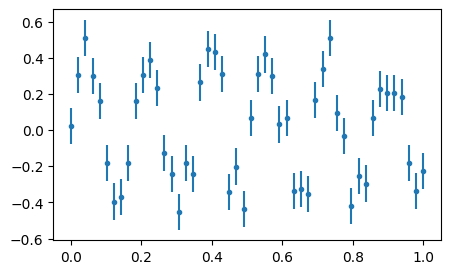

Samples outside prior N = 1926
surrogate posterior


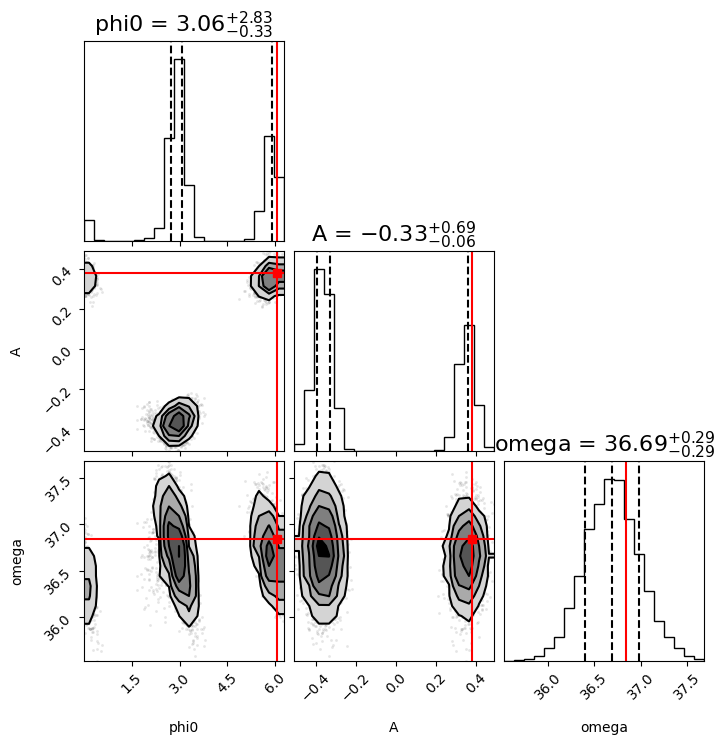

Generating simulations


1088it [00:00, 2183.55it/s]


Effective Sample Size = 804.0
Sampling efficiency = 6.3%


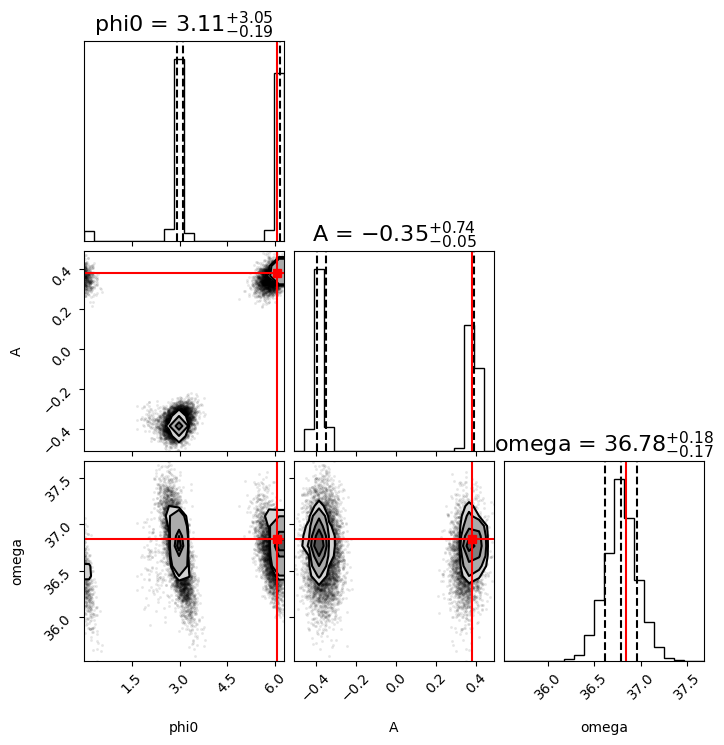

In [10]:
plt.figure(figsize=(5,3))
np.random.seed(4)

# draw random parameter from prior
y_true = [var.rvs(1)[0] for var in priors]
x_err = 0.1
x_obs = sine(y_true) + np.random.normal(size=50) * x_err
plt.errorbar(t, x_obs, yerr=x_err, fmt='.')
plt.show()

y_pred, weights = engine.predict(x_obs, x_err=np.array([0.1]*50), y_true=y_true, n_samples=12800, corner=True, corner_reweight=True)
plt.show()

## Use case 2: Sequential Neural Posterior Estimation (SNPE)
Let's say we only want to fit the specific sine curve above. In this case, we can train the model over multiple rounds to reduce the number of training samples required. The basic idea is to generate more training samples near the final posterior (as opposed to the broad prior).

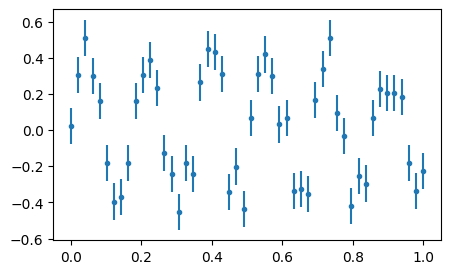

In [7]:
# Same test data as above
plt.figure(figsize=(5,3))
np.random.seed(4)

# draw random parameter from prior
y_true = [var.rvs(1)[0] for var in priors]
x_err = 0.1
x_obs = sine(y_true) + np.random.normal(size=50) * x_err
plt.errorbar(t, x_obs, yerr=x_err, fmt='.')
plt.show()

In [8]:
# hyperparameters remain the same as ANPE
flow = {
    'n_dims': 3,              # dimension of parameter space
    'flow_hidden': 64,
    'num_blocks': 5,
    'n_mog':4
}

# the NBI package provides the "ResNet-GRU" network as the default
# featurizer network for sequential data
featurizer = {
    'type': 'resnet-gru',
    'norm': 'weight_norm',
    'dim_in': 1,
    'dim_out': 64,
    'dim_conv_max': 256,
    'depth': 3
}

# initialize NBI engine
engine = nbi.NBI(
    flow=flow,
    featurizer=featurizer,
    simulator=sine,
    priors=priors,
    labels=labels,
    path='test2',
    device='cpu',
    n_jobs=10,
)

Auto learning rate to min_lr = 9.999999999999999e-06
Generating simulations


512it [00:00, 1845.76it/s]
/Users/Keming/anaconda3/envs/py311-arm/lib/python3.11/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/Keming/anaconda3/envs/py311-arm/lib/python3.11/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/Keming/anaconda3/envs/py311-arm/lib/python3.11/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
/Users/Keming/anaconda3/envs/py311-arm/lib/python3.11/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
  warnings.w

Effective sample size for current/all rounds 0.0/0.0

---------------------- Round: 0 ----------------------


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

- Val, Loglike in nats: 3.151944: 100%|██████████████████████████████████████████████████████████| 512/512 [00:00<00:00, 4444.60it/s]


Samples outside prior N = 284
Generating simulations


484it [00:00, 1808.32it/s]


Effective sample size for current/all rounds 16.5/16.5


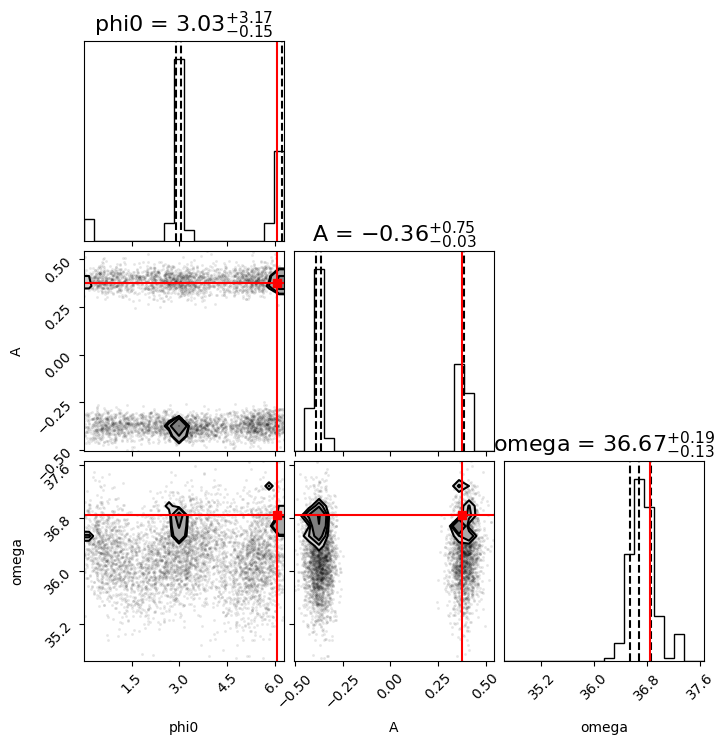

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)



---------------------- Round: 1 ----------------------


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

- Val, Loglike in nats: 1.945055:  53%|██████████████████████████████▋                           | 256/484 [00:00<00:00, 5519.47it/s]

Samples outside prior N = 300


Generating simulations


482it [00:00, 1319.40it/s]


Effective sample size for current/all rounds 714.3/730.8


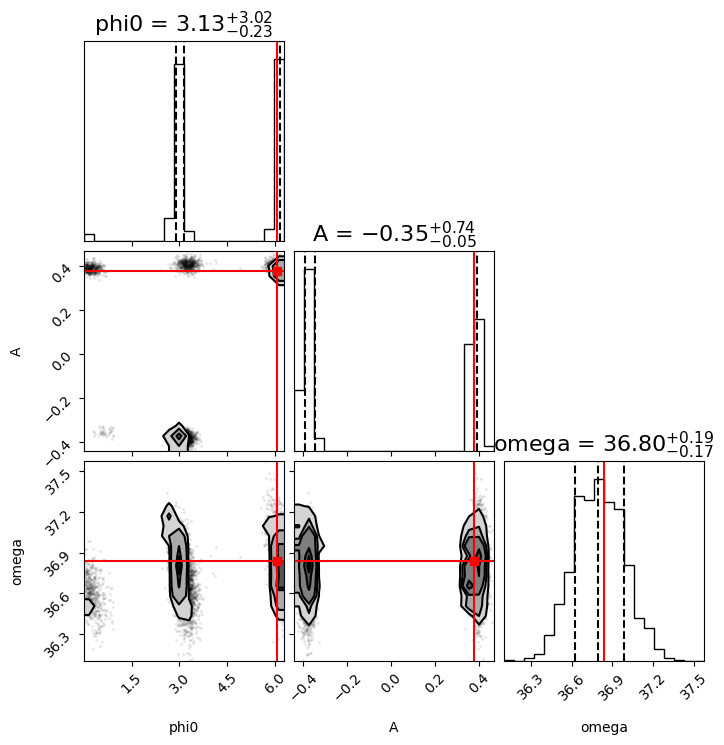

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)



---------------------- Round: 2 ----------------------


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

- Val, Loglike in nats: 2.221608:  53%|██████████████████████████████▊                           | 256/482 [00:00<00:00, 4168.09it/s]

Samples outside prior N = 88


Generating simulations


504it [00:00, 2715.34it/s]


Effective sample size for current/all rounds 1193.1/1923.9


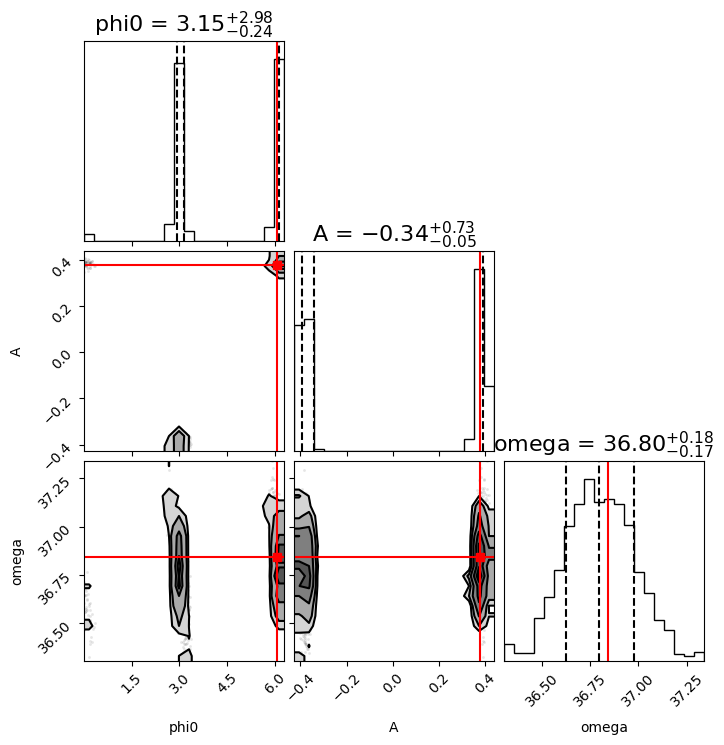

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)



---------------------- Round: 3 ----------------------


[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

- Val, Loglike in nats: 2.356997:  51%|█████████████████████████████▍                            | 256/504 [00:00<00:00, 6057.00it/s]


Samples outside prior N = 32
Generating simulations


509it [00:00, 2701.75it/s]


Effective sample size for current/all rounds 1059.6/2983.6


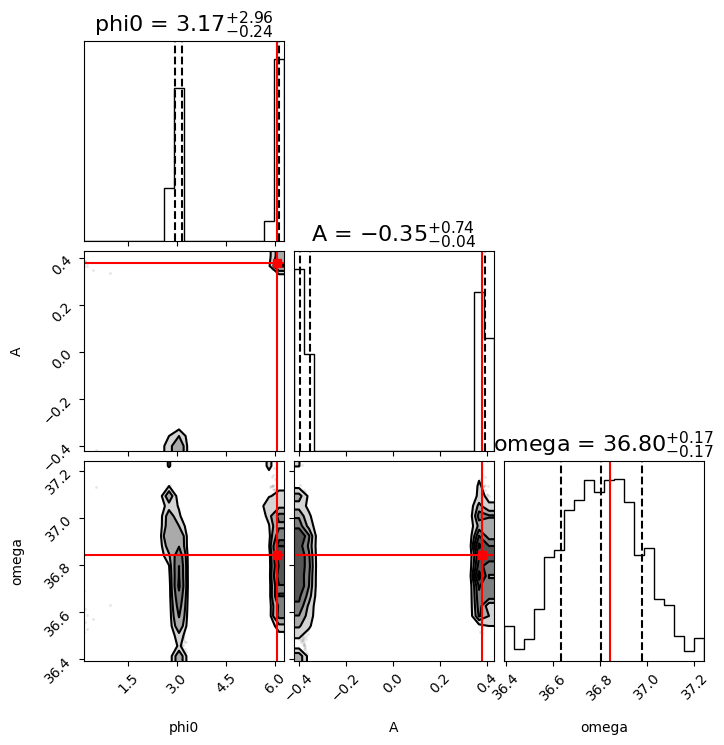

Early stop: Surrogate posterior did not improve for this round
Loaded state from round  2


In [9]:
engine.fit(
    x_obs=x_obs,
    y_true=y_true,
    n_sims=5120,                 # N=5120 per round
    n_rounds=5,                  # Max 5 rounds. (also see early_stop_train)
    n_epochs=50,
    batch_size=256,
    lr=0.001,
    early_stop_train=True,       # If sampling efficiency is reduced for this round, stop and revert to previous round
    early_stop_patience=10,      # Within a round, wait this many epochs before stopping training
    noise=np.array([0.1]*50)     # assume homogeneous noise; used for importance sampling
)

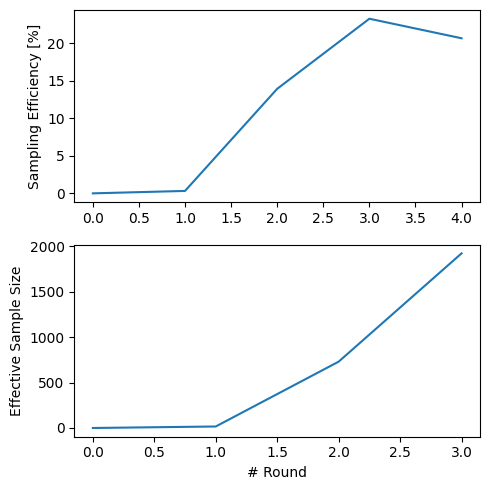

In [10]:
plt.rcParams['figure.dpi']=100
plt.figure(figsize=(5,5))
plt.subplot(211)
plt.plot(np.array(engine.neff)/5120*100)
plt.ylabel('Sampling Efficiency [%]')
plt.subplot(212)
plt.plot([np.sum(engine.neff[:i+1]) for i in range(4)])
plt.ylabel('Effective Sample Size')
plt.xlabel('# Round')
plt.tight_layout()

As we see, after the 3rd round of training the sampling efficiency is as high as ~25%, meaning the NDE posterior is nearly the true posterior. As expected, the 4th round of training degraded the result due to the use of NLL loss. Therefore, we revert the network to the 3rd round.

Note that every training round contributed to the final effective sample. The third round contributed 1059 effective posterior samples.

To generate more effective posterior samples, let us draw 10000 more samples from the 3nd round NDE. The first corner plot is the (unweighted) NDE surrogate posterior. The second one shows the importance reweighted posterior, which is asymptotically exact

Samples outside prior N = 177
surrogate posterior


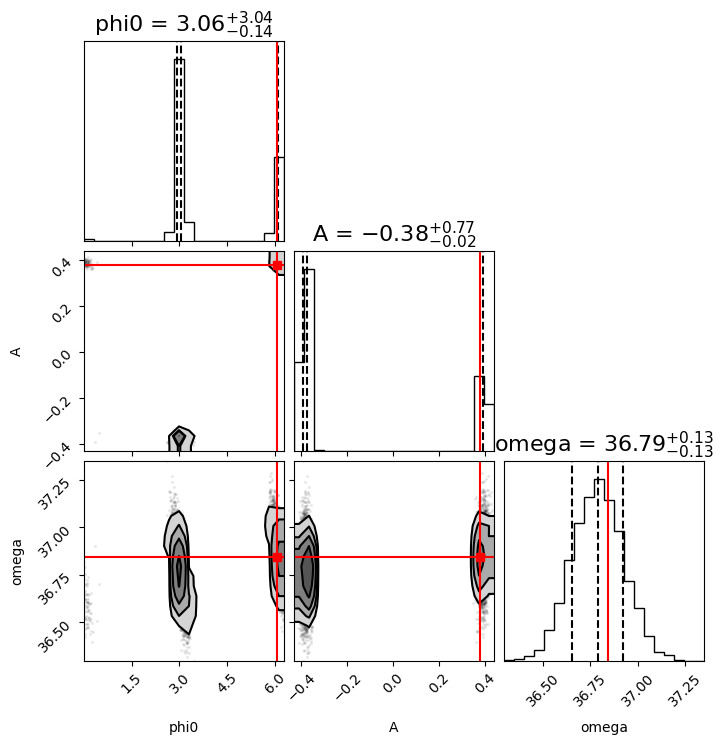

Generating simulations


983it [00:00, 3189.64it/s]


Effective Sample Size = 1680.1
Sampling efficiency = 16.8%


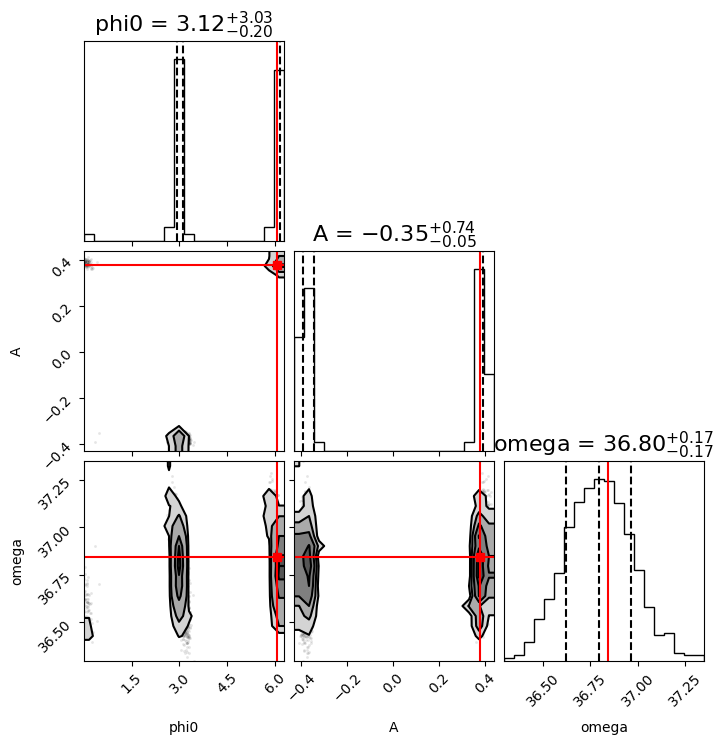

In [11]:
y_pred, weights = engine.predict(x_obs, x_err=np.array([0.1]*50),y_true=y_true, n_samples=10000, corner=True, corner_reweight=True)